# Task 2 — PyCaret ML Pipeline (Classification)

This section builds a complete ML pipeline using PyCaret, including:
- preprocessing pipeline (normalization, transformation, feature engineering)
- k-fold cross validation training and model selection
- evaluation using PyCaret plots
- predictions on unseen data
- saving the full pipeline
- MLflow experiment logging + model registration


In [ ]:
import os
import numpy as np
import pandas as pd

import mlflow
from pycaret.classification import *

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("lung_cancer_prediction_v1")


C:\Users\user\anaconda3\envs\mlops\lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
C:\Users\user\anaconda3\envs\mlops\lib\site-packages\pydantic\_internal\_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


<Experiment: artifact_location='file:///C:/Users/user/NYP/MLops/ML%20Ops%20Assignment/mlruns/956620094306968429', creation_time=1769934821616, experiment_id='956620094306968429', last_update_time=1769934821616, lifecycle_stage='active', name='lung_cancer_prediction_v1', tags={}>

## 1. Load Dataset

- Load cleaned dataset (from Task 1 cleaning stage)
- Remove accidental index columns (e.g., `Unnamed: 0`)
- Ensure target column exists and data types are reasonable


In [2]:
df = pd.read_csv("Dataset/Lung_Patient_Cleaned.csv")

# Remove common accidental index columns safely
bad_cols = [c for c in df.columns if c.strip().lower() in ["unnamed: 0", "index"]]
if bad_cols:
    df = df.drop(columns=bad_cols)

assert "Level" in df.columns, "Target column 'Level' not found."

display(df.head())
print("Shape:", df.shape)
print("Target distribution:\n", df["Level"].value_counts())


,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,Occupational_Hazards,Genetic_Risk,Chronic_Lung_Disease,Balanced_Diet,Obesity,...,Fatigue,Weight_Loss,Shortness_of_Breath,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


Shape: (1000, 24)
Target distribution:
 Level
High      365
Medium    332
Low       303
Name: count, dtype: int64


## 2. Train/Test Development Split vs Unseen Split

We hold out 10% as truly unseen data for final simulation (like production input).
This split is stratified by the target to preserve class distribution.


In [3]:
from sklearn.model_selection import train_test_split

data, data_unseen = train_test_split(
    df,
    test_size=0.10,
    random_state=RANDOM_SEED,
    stratify=df["Level"]
)

data = data.reset_index(drop=True)
data_unseen = data_unseen.reset_index(drop=True)

print("Data for modeling:", data.shape)
print("Unseen data:", data_unseen.shape)
print("\nModeling target distribution:\n", data["Level"].value_counts(normalize=True))
print("\nUnseen target distribution:\n", data_unseen["Level"].value_counts(normalize=True))


Data for modeling: (900, 24)
Unseen data: (100, 24)

Modeling target distribution:
 Level
High      0.364444
Medium    0.332222
Low       0.303333
Name: proportion, dtype: float64

Unseen target distribution:
 Level
High      0.37
Medium    0.33
Low       0.30
Name: proportion, dtype: float64


## 3. Initialize PyCaret Setup (Preprocessing Pipeline)

In this setup, we enable advanced preprocessing:
- normalization (scaling)
- transformation (Yeo-Johnson)
- multicollinearity removal
- optional feature engineering
- k-fold CV training configuration

This automatically builds a full transformation pipeline for deployment.


In [ ]:
exp = setup(
    data=data,
    target="Level",
    session_id=RANDOM_SEED,

    # Core preprocessing
    normalize=True,
    transformation=True,
    remove_multicollinearity=True,

    feature_selection=True,            # automatic feature selection
    fix_imbalance=False,               # set True if EDA shows imbalance; document your choice
    remove_outliers=False,             # optionally True if strong outliers exist

    # CV + logging
    fold=10,
    fold_strategy="stratifiedkfold",
    log_experiment=True,
    experiment_name="lung_cancer_prediction_v1",
    log_plots=True,
    verbose=True
)


,Description,Value
0,Session id,123
1,Target,Level
2,Target type,Multiclass
3,Target mapping,"High: 0, Low: 1, Medium: 2"
4,Original data shape,"(900, 24)"
5,Transformed data shape,"(900, 5)"
6,Transformed train set shape,"(630, 5)"
7,Transformed test set shape,"(270, 5)"
8,Numeric features,23
9,Preprocess,True


## 4. Compare Models with K-Fold Cross Validation

We compare multiple models under 10-fold stratified CV.
Because this is a multiclass target, we prioritize:
- Accuracy (overall correctness)
- Macro F1 (balanced performance across classes)

AUC is not always meaningful/available for multiclass for all estimators, so it is not used as the primary selection metric.


In [5]:
top3 = compare_models(
    sort="F1",      # macro F1 is often better for multiclass than accuracy alone
    n_select=3
)
top3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2070
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1950
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2260
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2620
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.5480
gbc,Gradient Boosting Classifier,0.9968,0.0000,0.9968,0.9970,0.9968,0.9952,0.9953,0.2870
dt,Decision Tree Classifier,0.9952,0.9965,0.9952,0.9955,0.9952,0.9928,0.9929,0.1650
knn,K Neighbors Classifier,0.9921,0.9976,0.9921,0.9926,0.9921,0.9881,0.9883,0.4910
qda,Quadratic Discriminant Analysis,0.8270,0.0000,0.8270,0.8340,0.8234,0.7400,0.7462,0.1380
nb,Naive Bayes,0.7937,0.9222,0.7937,0.8004,0.7895,0.6902,0.6966,0.1440


[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        monotonic_cst=None, n_estimators=100, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      monotonic_cst=None, n_estimators=100, n_jobs=-1,
                      oob_sc

## 5. Hyperparameter Tuning

We tune each of the top candidate models and select the best tuned model.
This improves generalization and fulfills the rubric requirement for tuning.


In [6]:
tuned_models = []
for m in top3:
    tuned = tune_model(m, n_iter=50, optimize="F1")
    tuned_models.append(tuned)

best_tuned = compare_models(include=tuned_models, sort="F1")
best_tuned


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9683,0.9985,0.9683,0.9713,0.9683,0.9523,0.9538
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9841,0.9877,0.9841,0.9848,0.9841,0.9761,0.9765
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9841,0.9996,0.9841,0.9849,0.9841,0.9761,0.9765
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9841,1.0000,0.9841,0.9849,0.9841,0.9761,0.9765


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2190
1,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2080
2,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1780


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

## 6. Model Evaluation (Holdout/Test Split)

We evaluate using PyCaret's plots for:
- confusion matrix
- classification report
- ROC (if supported)
- error analysis

These plots satisfy Task 2.3.


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

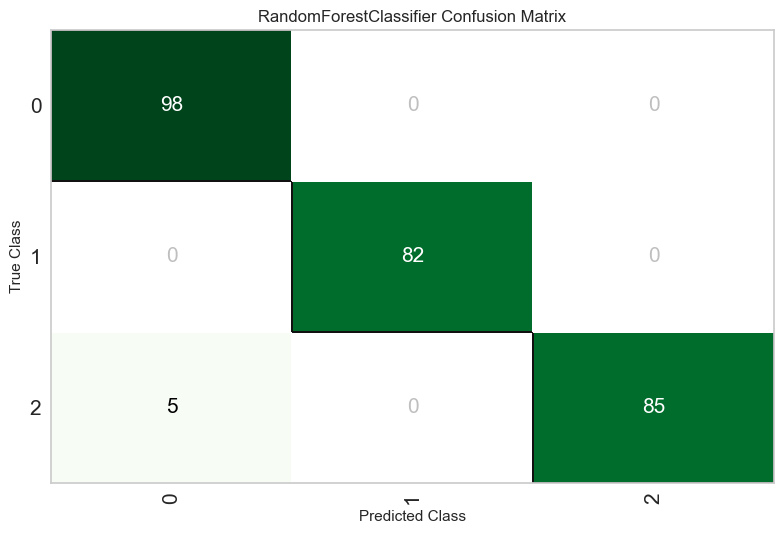

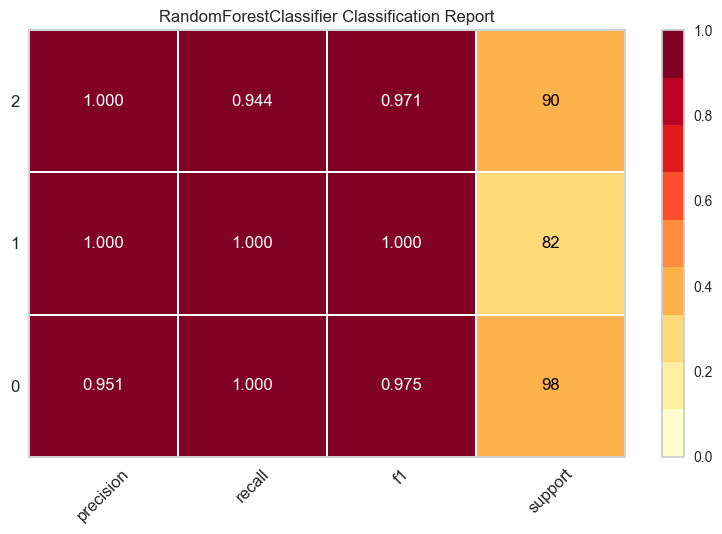

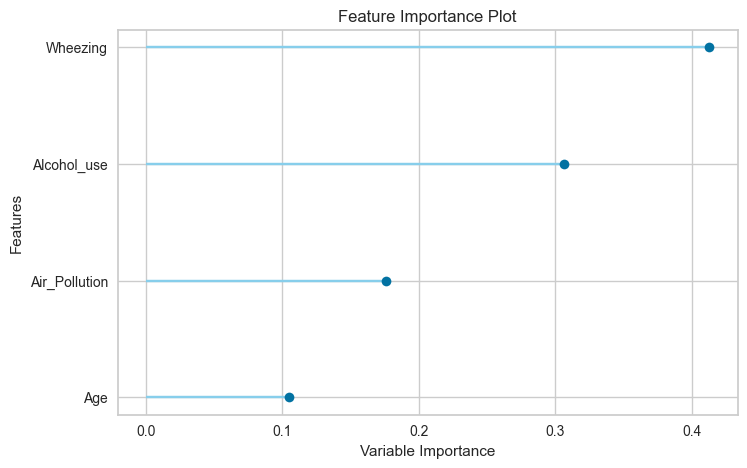

In [ ]:
# Interactive evaluation dashboard
evaluate_model(best_tuned)

plot_model(best_tuned, plot="confusion_matrix")
plot_model(best_tuned, plot="class_report")
plot_model(best_tuned, plot="feature")


## 7. Predictions on Holdout and Unseen Data

- `predict_model` on holdout validates model performance on PyCaret’s internal test split.
- `predict_model` on unseen data simulates real-world inference.


In [8]:
holdout_pred = predict_model(best_tuned)
holdout_pred.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9815,0.9994,0.9815,0.9824,0.9814,0.9721,0.9726


,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,Occupational_Hazards,Genetic_Risk,Chronic_Lung_Disease,Balanced_Diet,Obesity,...,Shortness_of_Breath,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level,prediction_label,prediction_score
645,23,1,3,2,4,2,3,2,3,3,...,6,5,5,4,6,5,4,Medium,Medium,1.0
130,26,2,8,8,7,7,7,6,7,7,...,4,1,4,2,4,2,3,High,High,1.0
280,29,2,6,7,7,7,7,6,7,7,...,6,7,6,7,2,3,1,High,High,1.0
897,42,1,2,4,5,6,5,5,4,6,...,7,3,8,9,1,6,2,High,High,1.0
811,37,2,6,8,7,7,7,6,7,7,...,5,7,2,4,3,1,4,High,High,1.0


In [9]:
unseen_pred = predict_model(best_tuned, data=data_unseen)
unseen_pred[["Level", "prediction_label", "prediction_score"]].head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9900,0.9998,0.9900,0.9903,0.9900,0.9849,0.9851


,Level,prediction_label,prediction_score
0,High,High,1.0
1,Medium,Medium,1.0
2,Low,Low,1.0
3,Low,Low,1.0
4,Medium,Medium,1.0


## 8. Finalize and Save the Entire Pipeline

Finalize trains on the full modeling dataset (train + holdout),
then we save the entire pipeline (preprocessing + model) for deployment.


In [10]:
final_pipeline = finalize_model(best_tuned)

save_model(final_pipeline, "lung_cancer_pipeline")  # creates lung_cancer_pipeline.pkl
print("Saved: lung_cancer_pipeline.pkl")


Transformation Pipeline and Model Successfully Saved
Saved: lung_cancer_pipeline.pkl


## 9. Register Model in MLflow Model Registry

We register the finalized pipeline as a versioned model.
This allows lifecycle management (versioning, staging, deployment tracking).


In [11]:
# Close any nested/active runs (PyCaret may have created runs)
while mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="final_pipeline_registration"):
    # Log model artifact
    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")

    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/model"

    # Register (creates a version)
    registered = mlflow.register_model(model_uri, "LungCancerPredictionModel")

print("Registered model:", registered.name, "version:", registered.version)


2026/02/01 17:12:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'backports-zstd'}
Registered model 'LungCancerPredictionModel' already exists. Creating a new version of this model...
2026/02/01 17:12:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LungCancerPredictionModel, version 2


Registered model: LungCancerPredictionModel version: 2


Created version '2' of model 'LungCancerPredictionModel'.


### Sanity Check

In [12]:
df_shuffled = data.copy()
df_shuffled["Level"] = np.random.permutation(df_shuffled["Level"].values)

_ = setup(
    data=df_shuffled,
    target="Level",
    session_id=RANDOM_SEED,
    normalize=True,
    transformation=True,
    remove_multicollinearity=True,
    fold=5,
    fold_strategy="stratifiedkfold",
    verbose=False
)

leakage_check_model = compare_models(sort="F1")
print(leakage_check_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.3444,0.0000,0.3444,0.3444,0.3414,0.0103,0.0104,0.0280
svm,SVM - Linear Kernel,0.3381,0.0000,0.3381,0.3434,0.3290,0.0054,0.0066,0.0500
gbc,Gradient Boosting Classifier,0.3222,0.0000,0.3222,0.3226,0.3201,-0.0248,-0.0251,0.1080
ada,Ada Boost Classifier,0.3254,0.0000,0.3254,0.3212,0.3195,-0.0202,-0.0210,0.0560
catboost,CatBoost Classifier,0.3190,0.4711,0.3190,0.3164,0.3155,-0.0284,-0.0286,0.5400
et,Extra Trees Classifier,0.3206,0.4664,0.3206,0.3179,0.3111,-0.0322,-0.0332,0.0860
dt,Decision Tree Classifier,0.3206,0.4658,0.3206,0.3170,0.3101,-0.0326,-0.0336,0.0280
lda,Linear Discriminant Analysis,0.3175,0.0000,0.3175,0.3127,0.3082,-0.0371,-0.0384,0.0260
lr,Logistic Regression,0.3159,0.0000,0.3159,0.3077,0.3045,-0.0404,-0.0419,0.0340
ridge,Ridge Classifier,0.3159,0.0000,0.3159,0.3076,0.3036,-0.0410,-0.0430,0.0320


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
